In [11]:
import pandas as pd
import numpy as np
import pandas_ta as ta
import ccxt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import plotly.graph_objects as go
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

In [12]:
binance = ccxt.binanceusdm({'options': {'defaultType': 'future'}})
symbol = 'BTC/USDT'
timeframe = '15m'
start_date = '2025-01-01T00:00:00Z'
end_date = '2025-08-31T23:59:59Z'

all_ohlcv = []
since = binance.parse8601(start_date)
end_timestamp = binance.parse8601(end_date)
print(f"Starting {timeframe} data download from Binance Futures...")

while since < end_timestamp:
    try:
        ohlcv = binance.fetch_ohlcv(symbol, timeframe, since, limit=1000)
        if not ohlcv: break
        print(f"Fetched {len(ohlcv)} candles up to {pd.to_datetime(ohlcv[-1][0], unit='ms')}")
        since = ohlcv[-1][0] + (4 * 3600 * 1000)
        all_ohlcv.extend(ohlcv)
    except Exception as e:
        print(f"An error occurred: {e}"); break

df = pd.DataFrame(all_ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
if not df.empty:
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df.set_index('timestamp', inplace=True)
    print(f"\n✅ Total data loaded: {len(df)} candles from {df.index.min()} to {df.index.max()}")

Starting 15m data download from Binance Futures...
Fetched 1000 candles up to 2025-01-11 09:45:00
Fetched 1000 candles up to 2025-01-21 23:30:00
Fetched 1000 candles up to 2025-02-01 13:15:00
Fetched 1000 candles up to 2025-02-12 03:00:00
Fetched 1000 candles up to 2025-02-22 16:45:00
Fetched 1000 candles up to 2025-03-05 06:30:00
Fetched 1000 candles up to 2025-03-15 20:15:00
Fetched 1000 candles up to 2025-03-26 10:00:00
Fetched 1000 candles up to 2025-04-05 23:45:00
Fetched 1000 candles up to 2025-04-16 13:30:00
Fetched 1000 candles up to 2025-04-27 03:15:00
Fetched 1000 candles up to 2025-05-07 17:00:00
Fetched 1000 candles up to 2025-05-18 06:45:00
Fetched 1000 candles up to 2025-05-28 20:30:00
Fetched 1000 candles up to 2025-06-08 10:15:00
Fetched 1000 candles up to 2025-06-19 00:00:00
Fetched 1000 candles up to 2025-06-29 13:45:00
Fetched 1000 candles up to 2025-07-10 03:30:00
Fetched 1000 candles up to 2025-07-20 17:15:00
Fetched 1000 candles up to 2025-07-31 07:00:00
Fetched 1

In [13]:
print("Calculating indicators and creating Ichimoku core signals...")

df.ta.ichimoku(append=True)
df.ta.rsi(length=14, append=True)
df.ta.obv(append=True)
df.ta.atr(length=14, append=True)

features = [
    'open', 'high', 'low', 'close', 'volume',
    'ITS_9', 'IKS_26', 'ISA_9', 'ISB_26', 'ICS_26',
    'RSI_14', 'OBV', 'ATRr_14'
]
df.dropna(subset=features, inplace=True)

kumo_high = df[['ISA_9', 'ISB_26']].max(axis=1)
kumo_low = df[['ISA_9', 'ISB_26']].min(axis=1)

is_price_above_kumo = df['close'] > kumo_high
is_price_below_kumo = df['close'] < kumo_low
is_tenkan_above_kijun = df['ITS_9'] > df['IKS_26']

long_signal = is_price_above_kumo & is_tenkan_above_kijun
short_signal = is_price_below_kumo & ~is_tenkan_above_kijun

df['signal'] = 0
df.loc[long_signal & ~long_signal.shift(1).fillna(False), 'signal'] = 1
df.loc[short_signal & ~short_signal.shift(1).fillna(False), 'signal'] = -1

print("\nIchimoku core signal distribution (2-role):")
print(df['signal'].value_counts())

Calculating indicators and creating Ichimoku core signals...

Ichimoku core signal distribution (2-role):
signal
 0    21648
 1      589
-1      548
Name: count, dtype: int64


In [14]:
def create_hybrid_labels(df, look_ahead, atr_multiplier_tp, atr_multiplier_sl):
    labels = pd.Series(0, index=df.index)
    signals = df[df['signal'] != 0].index
    
    for sig_idx in tqdm(signals, desc="Creating Hybrid Labels"):
        entry_price = df.loc[sig_idx, 'close']
        atr = df.loc[sig_idx, 'ATRr_14']
        signal_type = df.loc[sig_idx, 'signal']
        
        take_profit = entry_price + (atr * atr_multiplier_tp) if signal_type == 1 else entry_price - (atr * atr_multiplier_tp)
        stop_loss = entry_price - (atr * atr_multiplier_sl) if signal_type == 1 else entry_price + (atr * atr_multiplier_sl)

        outcome_df = df.loc[sig_idx + pd.Timedelta(hours=4):sig_idx + pd.Timedelta(hours=look_ahead*4)]
        
        for i in range(len(outcome_df)):
            if (signal_type == 1 and outcome_df['high'].iloc[i] >= take_profit) or (signal_type == -1 and outcome_df['low'].iloc[i] <= take_profit):
                labels.loc[sig_idx] = 1 if signal_type == 1 else 2; break
            elif (signal_type == 1 and outcome_df['low'].iloc[i] <= stop_loss) or (signal_type == -1 and outcome_df['high'].iloc[i] >= stop_loss):
                break 
    return labels

def create_sequences(data, labels, sequence_length):
    X, y = [], []
    signal_indices = labels.index[labels.index.isin(df[df['signal'] != 0].index)]
    for idx in tqdm(signal_indices, desc="Creating Sequences"):
        end_loc = data.index.get_loc(idx) + 1
        start_loc = end_loc - sequence_length
        if start_loc < 0: continue
        X.append(data.iloc[start_loc:end_loc].values)
        y.append(labels.loc[idx])
    return np.array(X), np.array(y)

SEQUENCE_LENGTH = 12
LOOK_AHEAD = 24
df['labels'] = create_hybrid_labels(df, LOOK_AHEAD, 3.0, 1.5)

scaler = MinMaxScaler()
scaled_features_df = pd.DataFrame(scaler.fit_transform(df[features]), index=df.index, columns=features)

X, y = create_sequences(scaled_features_df, df['labels'], SEQUENCE_LENGTH)
y_cat = to_categorical(y, num_classes=3)

if len(X) > 10:
    X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.3, random_state=42, stratify=y)
    print(f"\nTotal signals for training/testing: {len(X)}")
else:
    X_train, X_test, y_train, y_test = [], [], [], []
    print(f"\n[Error] Not enough signals ({len(X)}) to train the model.")

Creating Sequences: 100%|████████████████| 1137/1137 [00:00<00:00, 10331.29it/s]


Total signals for training/testing: 1136


In [15]:
def create_lstm_model(sequence_length, num_features):
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=(sequence_length, num_features)),
        Dropout(0.2),
        LSTM(64, return_sequences=False),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(3, activation='softmax')
    ])
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model, early_stopping

if len(X_train) > 0:
    model, early_stopping = create_lstm_model(SEQUENCE_LENGTH, len(features))
    model.summary()
    model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)
else:
    model = None

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 12, 64)         │        19,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 55,171 (215.51 KB)

 Trainable params: 55,171 (215.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - accuracy: 0.6138 - loss: 0.9519 - val_accuracy: 0.6246 - val_loss: 0.9289
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6239 - loss: 0.9334 - val_accuracy: 0.6246 - val_loss: 0.9212
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.6239 - loss: 0.9319 - val_accuracy: 0.6246 - val_loss: 0.9168
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.6239 - loss: 0.9228 - val_accuracy: 0.6246 - val_loss: 0.9129
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.6239 - loss: 0.9253 - val_accuracy: 0.6246 - val_loss: 0.9112
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.6239 - loss: 0.9199 - val_accuracy: 0.6246 - val_loss: 0.9146
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.6239 - loss: 0.9178 - val_accuracy: 0.6246 - val_loss: 0.9084
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.6201 - loss: 0.9141 - val_accuracy: 0.

In [16]:
if model is not None:
    print("\n--- Starting Hybrid Backtest (Ichimoku 2-Role Strategy) ---")

    INITIAL_CAPITAL = 10000
    RISK_PER_TRADE = 0.02
    LEVERAGE = 5
    TAKER_FEE = 0.0004
    PROB_THRESHOLD = 0.55
    ATR_SL_MULTIPLIER = 1.5
    ATR_TP_MULTIPLIER = 3.0

    equity_curve = [INITIAL_CAPITAL]
    trades = []
    position = None

    test_start_index = int(len(df) * 0.7)
    test_df = df.iloc[test_start_index:].copy()

    test_scaled_features = scaler.transform(test_df[features])
    test_scaled_features_df = pd.DataFrame(test_scaled_features, index=test_df.index, columns=features)

    for i in tqdm(range(len(test_df)), desc="Hybrid Backtesting"):
        row = test_df.iloc[i]
        current_price = row['close']
        current_capital = equity_curve[-1]

        if position is not None and ((position['type'] == 'long' and (current_price <= position['sl'] or current_price >= position['tp'])) or (position['type'] == 'short' and (current_price >= position['sl'] or current_price <= position['tp']))):
            exit_price = current_price
            pnl = (exit_price - position['entry']) * position['size'] if position['type'] == 'long' else (position['entry'] - exit_price) * position['size']
            pnl -= position['fee']
            position = None
            current_capital += pnl
            trades.append({'profit': pnl})

        if position is None and row['signal'] != 0:
            seq_start_idx = test_df.index.get_loc(row.name) - SEQUENCE_LENGTH + 1
            if seq_start_idx >= 0:
                current_sequence_scaled = test_scaled_features_df.iloc[seq_start_idx:seq_start_idx + SEQUENCE_LENGTH].values
                prediction = model.predict(np.expand_dims(current_sequence_scaled, axis=0), verbose=0)[0]
                pred_class, pred_prob = np.argmax(prediction), np.max(prediction)
                
                human_signal = row['signal']
                ai_signal = 1 if pred_class == 1 else (-1 if pred_class == 2 else 0)
                
                if pred_prob > PROB_THRESHOLD and human_signal == ai_signal:
                    risk_amount = current_capital * RISK_PER_TRADE
                    stop_loss_dist = row['ATRr_14'] * ATR_SL_MULTIPLIER
                    if stop_loss_dist > 0:
                        position_size = risk_amount / stop_loss_dist
                        fee = (position_size * current_price * TAKER_FEE) * 2
                        entry_params = {'entry': current_price, 'size': position_size, 'fee': fee}
                        if human_signal == 1:
                            position = {'type': 'long', **entry_params, 'sl': current_price - stop_loss_dist, 'tp': current_price + row['ATRr_14'] * ATR_TP_MULTIPLIER}
                        elif human_signal == -1:
                            position = {'type': 'short', **entry_params, 'sl': current_price + stop_loss_dist, 'tp': current_price - row['ATRr_14'] * ATR_TP_MULTIPLIER}
        
        equity_curve.append(current_capital)
else:
    print("Backtest skipped as the model was not trained.")


--- Starting Hybrid Backtest (Ichimoku 2-Role Strategy) ---


Hybrid Backtesting: 100%|██████████████████| 6836/6836 [00:42<00:00, 161.96it/s]



--- Hybrid Backtest Results (Ichimoku 2-Role Strategy) ---
Final Capital: $46,020.54
Total Return: 360.21%
-------------------------
Total Trades: 54 (AI Filtered)
Win Rate: 77.78%
Profit Factor: 5.64
Max Drawdown (MDD): 8.15%
-------------------------


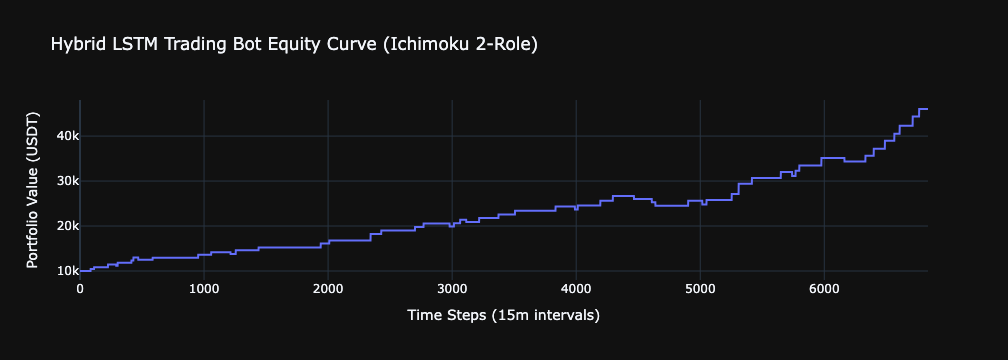

In [18]:
if 'model' in locals() and model is not None and trades:
    final_capital = equity_curve[-1]
    trades_df = pd.DataFrame(trades)
    
    total_return = (final_capital - INITIAL_CAPITAL) / INITIAL_CAPITAL * 100
    num_trades = len(trades_df)
    wins = trades_df[trades_df['profit'] > 0]
    win_rate = len(wins) / num_trades if num_trades > 0 else 0
    profit_factor = abs(wins['profit'].sum() / trades_df[trades_df['profit'] <= 0]['profit'].sum()) if trades_df[trades_df['profit'] <= 0]['profit'].sum() != 0 else np.inf

    equity_s = pd.Series(equity_curve)
    mdd = abs((equity_s / equity_s.cummax() - 1).min()) * 100

    print("\n--- Hybrid Backtest Results (Ichimoku 2-Role Strategy) ---")
    print(f"Final Capital: ${final_capital:,.2f}")
    print(f"Total Return: {total_return:.2f}%")
    print("-" * 25)
    print(f"Total Trades: {num_trades} (AI Filtered)")
    print(f"Win Rate: {win_rate:.2%}")
    print(f"Profit Factor: {profit_factor:.2f}")
    print(f"Max Drawdown (MDD): {mdd:.2f}%")
    print("-" * 25)

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=list(range(len(equity_curve))), y=equity_curve, mode='lines', name='Equity Curve'))
    fig.update_layout(title='Hybrid LSTM Trading Bot Equity Curve (Ichimoku 2-Role)', xaxis_title=f'Time Steps ({timeframe} intervals)', yaxis_title='Portfolio Value (USDT)', template='plotly_dark')
    fig.show()

else:
    print("\n--- Backtest Results ---")
    print("No trades were executed. Try adjusting the PROB_THRESHOLD or the core strategy.")